# Gator AI Summer Camp 2024

In this first notebook, we're going to use Python to create a deep learning model that can take images of faces and output the emotion being expressed.

The dataset we're going to use is the FER-2013 dataset, which contains 35,887 grayscale images of faces. Each image is 48x48 pixels and is labeled with one of seven emotions: anger, disgust, fear, happiness, sadness, surprise, or neutral. The dataset and more information can be found [on Kaggle](https://www.kaggle.com/datasets/msambare/fer2013/data).

**Note:** One issue with the dataset is that it has relatively few images in the disgust category, so we drop that category for this exercise.

To build our model, we'll use the Keras deep learning library, which provides a high-level interface for building and training neural networks. We'll start by loading the dataset and exploring the images, then we'll build and train a convolutional neural network (CNN) to classify the emotions in the images.

Before you get started, make sure to select a Runtime with a GPU!
* Go to the Runtime menu
* Select "Change runtime type"
* Select "T4 GPU" and click "Save"

In [4]:
# Import the necessary libraries
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from functools import reduce
import itertools
from collections import Counter


# Import the libraries for CNNs
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight

# Import the libraries for the evaluation
from sklearn.metrics import classification_report, confusion_matrix


In [14]:
# Download the data from Kaggle and unzip into data directory
# Lines that start with ! are run as BASH or command line code, not Python
!kaggle datasets download -d msambare/fer2013
!mkdir data
!unzip fer2013.zip -d data/

#Delete the disgust folders as there are so few examples in that cetegory.
!rm -rf data/train/disgust
!rm -rf data/test/disgust

***********************************************************************
Load data:
  - Loading the dataset from: data/.
  - Using a batch size of: 32.
  - Resizing input images to: (80, 80, 1).
  - Data augmentation: True.
  - Balance classes: True.
***********************************************************************
Found 28273 files belonging to 6 classes.
Found 7067 files belonging to 6 classes.
['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']


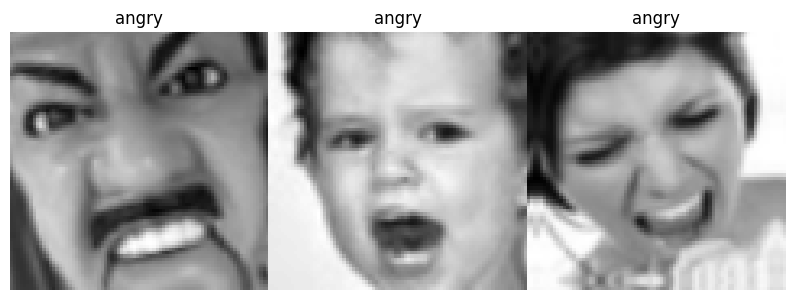

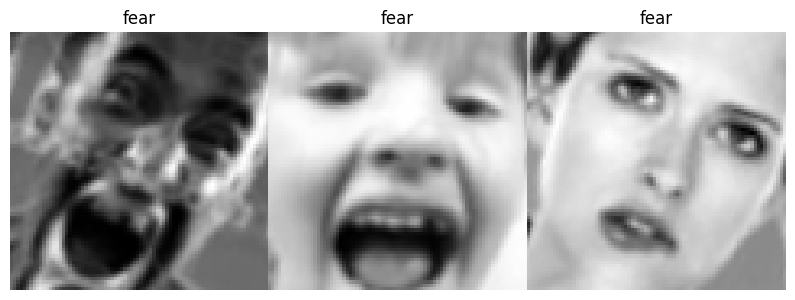

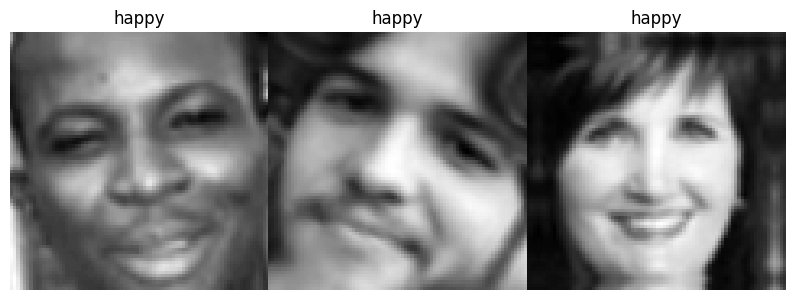

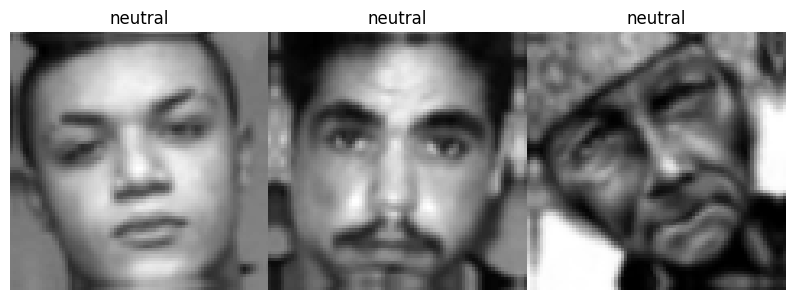

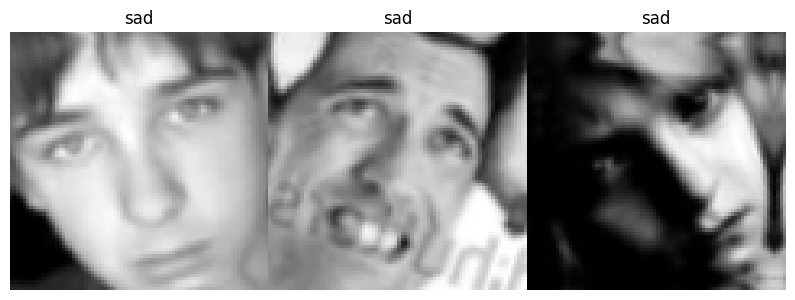

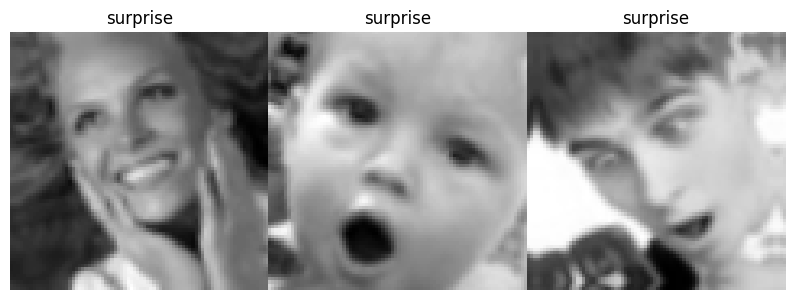

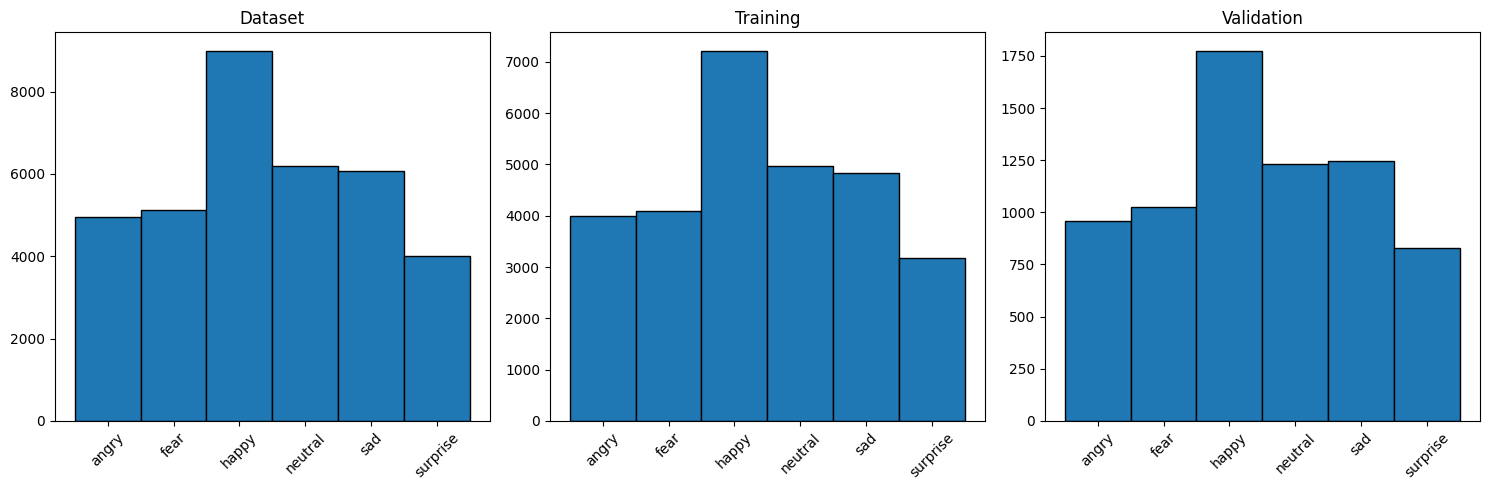

In [15]:
def load_display_data(path, batch_size=32, shape=(80, 80, 1), show_pictures=True, show_histogram=True, augment=False, balance_classes=False):
    '''Takes a path, batch size, target shape for images and optionally whether to show sample images, augment data, and balance classes.
       Returns training and testing datasets
    '''
    print("***********************************************************************")
    print("Load data:")
    print(f"  - Loading the dataset from: {path}.")
    print(f"  - Using a batch size of: {batch_size}.")
    print(f"  - Resizing input images to: {shape}.")
    print(f"  - Data augmentation: {augment}.")
    print(f"  - Balance classes: {balance_classes}.")
    print("***********************************************************************")

    # Define the directory path
    directory_path = path

    # Define the batch size
    batch_size = batch_size

    # Define the image size using the 1st 2 elements of the shape parameter
    # We don't need the number of channels here, just the dimensions to use
    image_size = shape[:2]

    # Create the data augmentation pipeline if augmentation is enabled
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
        tf.keras.layers.experimental.preprocessing.RandomContrast(0.1)
    ]) if augment else None

    # Load the dataset
    X_train = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(directory_path, 'train'),
        batch_size=batch_size,
        image_size=image_size,
        labels='inferred',
        label_mode='int',
        color_mode='grayscale'
    )

    X_val = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(directory_path, 'test'),
        batch_size=batch_size,
        image_size=image_size,
        labels='inferred',
        label_mode='int',
        color_mode='grayscale'
    )

    # Store class names before transforming the dataset
    class_names = X_train.class_names


    # Apply data augmentation to the training dataset if enabled
    if augment:
        X_train = X_train.map(lambda x, y: (data_augmentation(x, training=True), y))

    if show_pictures:
        print(class_names)

        # Display up to 3 images from each of the categories
        class_images_dict = {class_name: [] for class_name in class_names}

        # Collect images for each class
        for images, labels in X_train:
            images = images.numpy()
            labels = labels.numpy()

            for i, class_name in enumerate(class_names):
                if len(class_images_dict[class_name]) < 3:
                    # Filter images of the current class
                    class_images = images[labels == i]
                    class_images_dict[class_name].extend(class_images[:3 - len(class_images_dict[class_name])])

            # Break if we have collected enough images for all classes
            if all(len(imgs) >= 3 for imgs in class_images_dict.values()):
                break

        # Display the collected images
        for class_name, class_images in class_images_dict.items():
            fig, axs = plt.subplots(1, 3, figsize=(10, 10))
            fig.subplots_adjust(wspace=0, hspace=30)  # Adjust the space between subplots

            for j in range(len(class_images)):
                ax = axs[j]
                ax.imshow(class_images[j].astype("uint8"), cmap='gray')
                ax.set_title(class_name)
                ax.axis("off")
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                ax.set_aspect('equal')

            plt.show()

    train_labels = []

    if show_histogram:
        # Collect all labels for training and validation datasets
        for images, labels in X_train:
            train_labels.extend(labels.numpy())

        val_labels = []
        for images, labels in X_val:
            val_labels.extend(labels.numpy())

        # Display the class distribution for the entire dataset
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.title("Dataset")
        # Title for the total dataset
        plt.hist(train_labels + val_labels, bins=np.arange(len(class_names) + 1) - 0.5, edgecolor='black')
        plt.xticks(range(len(class_names)), labels=class_names, rotation=45)

        plt.subplot(1, 3, 2)
        plt.title("Training")
        plt.hist(train_labels, bins=np.arange(len(class_names) + 1) - 0.5, edgecolor='black')
        plt.xticks(range(len(class_names)), labels=class_names, rotation=45)

        plt.subplot(1, 3, 3)
        plt.title("Validation")
        plt.hist(val_labels, bins=np.arange(len(class_names) + 1) - 0.5, edgecolor='black')
        plt.xticks(range(len(class_names)), labels=class_names, rotation=45)

        plt.tight_layout()
        plt.show()

    if balance_classes:
        class_weights = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(train_labels),
            y=train_labels
        )
        class_weights = tf.constant(list(class_weights))  # Convert to TensorFlow constant

        # Apply class weights to the training dataset using tf.gather
        X_train = X_train.map(lambda img, label: (img, label, tf.gather(class_weights, tf.cast(label, tf.int32))))

        # (If needed, you could also adjust the validation set weights, but typically not necessary)
        # X_val = X_val.map(lambda img, label: (img, label, tf.gather(class_weights, tf.cast(label, tf.int32))))

    return X_train, X_val

data_path = 'data/'

X_train, X_val = load_display_data(data_path, batch_size=32, shape=(80, 80, 1), show_pictures=True, show_histogram=True, augment=True, balance_classes=True)

In [16]:
# Define the CNN model architecture

def create_model(input_shape, num_classes, padding='same', activation='relu', dropout_rate=0.2):
    '''Takes the input shape and number of classes and returns a CNN model'''
    print("***********************************************************************")
    print("Create model:")
    print(f"  - Input shape: {input_shape}.")
    print(f"  - Number of classes: {num_classes}.")
    print("***********************************************************************")
    # Create the model
    model = Sequential([
        Conv2D(16, 3, padding=padding, activation=activation, input_shape=input_shape),
        MaxPooling2D(),
        Dropout(dropout_rate),
        Conv2D(32, 3, padding=padding, activation=activation),
        MaxPooling2D(),
        Dropout(dropout_rate),
        Conv2D(64, 3, padding=padding, activation=activation),
        MaxPooling2D(),
        Dropout(dropout_rate),
        Flatten(),
        Dense(128, activation=activation),
        Dense(num_classes, activation='softmax')
    ])
    # Visualize the model
    model.summary()

    return model

# Define our instance of the model

input_shape = (80, 80, 1)
num_classes = 6

model = create_model(input_shape, num_classes, padding='same', activation='relu')



***********************************************************************
Create model:
  - Input shape: (80, 80, 1).
  - Number of classes: 6.
***********************************************************************
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 80, 80, 16)        160       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 40, 40, 16)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 40, 40, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 40, 40, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 20

In [18]:
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')

In [19]:
# Train the model
history = model.fit(X_train, validation_data=X_val, epochs=30, callbacks=[early_stop])

Epoch 1/30
884/884 [==============================] - 26s 28ms/step - loss: 2.5538 - accuracy: 0.1672 - val_loss: 1.7899 - val_accuracy: 0.2309
Epoch 2/30
884/884 [==============================] - 24s 27ms/step - loss: 1.7903 - accuracy: 0.1848 - val_loss: 1.7842 - val_accuracy: 0.2505
Epoch 3/30
884/884 [==============================] - 28s 32ms/step - loss: 1.7878 - accuracy: 0.1941 - val_loss: 1.7744 - val_accuracy: 0.2022
Epoch 4/30
884/884 [==============================] - 26s 29ms/step - loss: 1.7545 - accuracy: 0.2308 - val_loss: 1.7286 - val_accuracy: 0.2819
Epoch 5/30
884/884 [==============================] - 27s 31ms/step - loss: 1.7156 - accuracy: 0.2546 - val_loss: 1.6743 - val_accuracy: 0.2911
Epoch 6/30
884/884 [==============================] - 26s 30ms/step - loss: 1.6904 - accuracy: 0.2749 - val_loss: 1.6506 - val_accuracy: 0.3158
Epoch 7/30
884/884 [==============================] - 29s 33ms/step - loss: 1.6767 - accuracy: 0.2938 - val_loss: 1.6452 - val_accuracy:

***********************************************************************
Accuracy and Loss per Epoch:
***********************************************************************
221/221 [==============================] - 1s 6ms/step - loss: 1.2544 - accuracy: 0.5112
Loss: 1.254400372505188, Accuracy: 0.5112494826316833


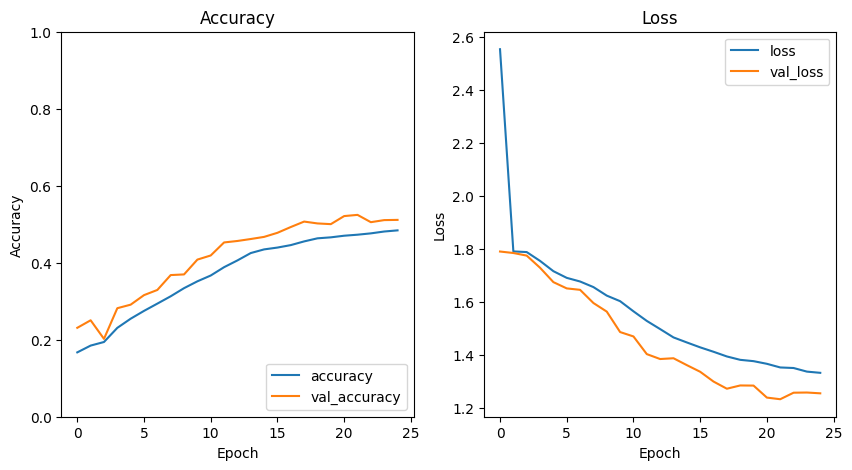

***********************************************************************
Confusion matrix:
***********************************************************************
221/221 [==============================] - 1s 5ms/step


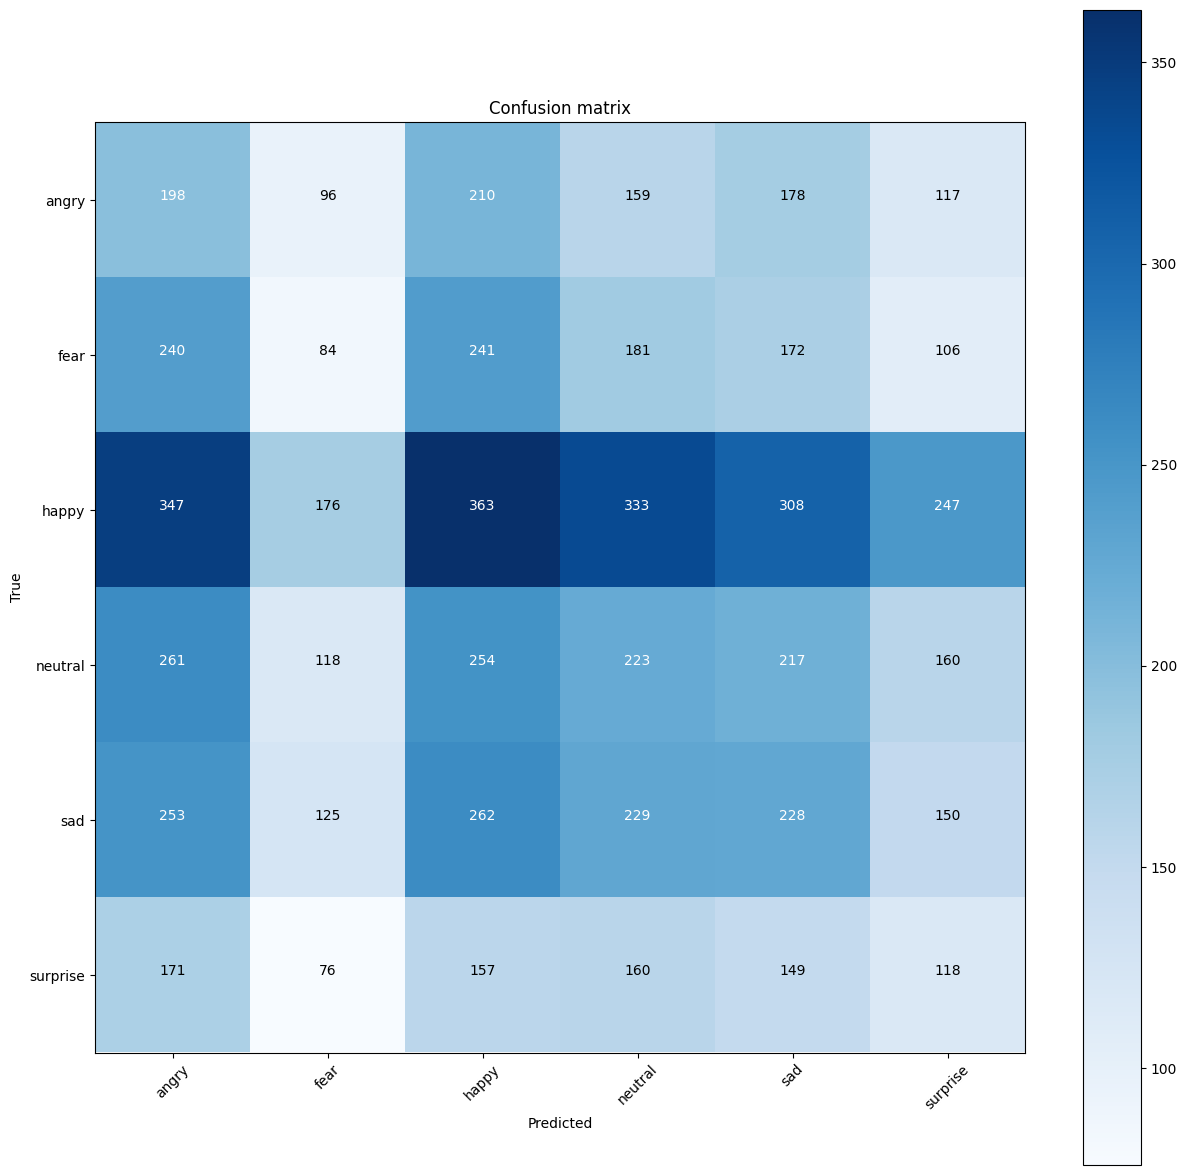

In [20]:
# Evaluate the model
print("***********************************************************************")
print("Accuracy and Loss per Epoch:")
print("***********************************************************************")
loss, accuracy = model.evaluate(X_val)
print(f"Loss: {loss}, Accuracy: {accuracy}")

# Plot the training history
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title("Loss")
plt.show()

# Define a function to plot the confusion matrix
def plot_confusion_matrix(model, dataset):
    print("***********************************************************************")
    print("Confusion matrix:")
    print("***********************************************************************")

    # Get the true labels
    y_true = []
    for images, labels in dataset:
        y_true.extend(labels.numpy())

    # Get the predicted labels
    y_pred = model.predict(dataset)
    y_pred = np.argmax(y_pred, axis=1)

    # Get the class names
    class_names = dataset.class_names

    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(15, 15))
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(range(len(class_names)), labels=class_names, rotation=45)
    plt.yticks(range(len(class_names)), labels=class_names)

    # Annotate each cell with the numeric value
    thresh = cm.max() / 2
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.show()

# Example usage (assuming X_val is your validation dataset)
plot_confusion_matrix(model, X_val)

## Save our model

Now that we've trained our model, we can save it for the next steps where we will want to use the model.


In [22]:
model.save('emotion_model.keras')